<a href="https://colab.research.google.com/github/olonok69/projects_ai/blob/main/CSM_generate_Embeddings_badges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMBEDDINGS
Embeddings in the context of large language models (LLMs) are dense vector representations of text. They are a way to convert words, phrases, or even entire documents into numerical form so that they can be processed by machine learning models.

### What Are Embeddings?
- Vector Representation: Embeddings transform text into vectors (arrays of numbers). Each dimension of the vector captures some aspect of the text's meaning.

- Dimensionality Reduction: Instead of representing words as sparse vectors (like one-hot encoding), embeddings use dense vectors with much lower dimensionality, making computations more efficient.

- Semantic Meaning: Words with similar meanings are mapped to vectors that are close to each other in the embedding space. For example, the words "king" and "queen" would have similar embeddings.

### How Are They Used in LLMs?
- Input Representation: When text is fed into an LLM, it is first converted into embeddings. These embeddings serve as the input to the model.

- Contextual Understanding: LLMs like BERT, GPT, and Mistral generate embeddings that capture the context of words within a sentence. This means the same word can have different embeddings depending on its context.

- Downstream Tasks: Embeddings are used for various NLP tasks such as text classification, sentiment analysis, and information retrieval. They can also be used in recommendation systems, as you mentioned earlier.


The choice between using the last hidden layer or the second-to-last hidden layer for embeddings can depend on your specific task and model. Here are some considerations:

- Last Hidden Layer: This layer contains the most contextually rich and semantically meaningful representations of the input text. It's often used because it captures the final output of the model's processing.

- Second-to-Last Hidden Layer: Some studies suggest that the second-to-last layer can provide better embeddings for certain tasks. This is because the last layer might be too specialized for the model's training objective (e.g., masked language modeling), while the second-to-last layer retains more general features

# MTEB
MTEB is a massive benchmark for measuring the performance of text embedding models on diverse embedding tasks.

- https://huggingface.co/blog/mteb
- https://huggingface.co/spaces/mteb/leaderboard

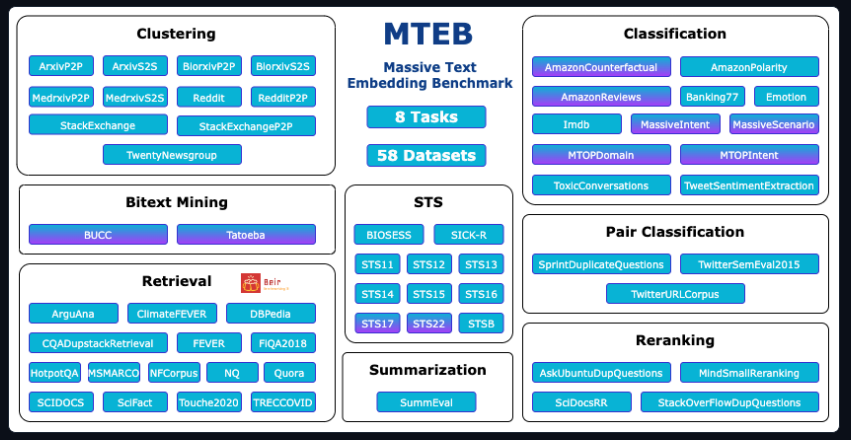


# large EMbeddings vs Small Embeddings
The choice between using large or small embeddings depends on your specific needs and constraints. Here are some key points to consider:

#### Large Embeddings
Pros:

- Richer Representations: Larger embeddings capture more nuanced and detailed information, which can improve performance on complex tasks1.
- Better Contextual Understanding: They often provide a deeper understanding of the text, which is beneficial for tasks requiring high accuracy1.

Cons:

- Higher Computational Cost: They require more memory and processing power, which can be a limitation for real-time applications or when working with large datasets1.
- Increased Cost: Larger embeddings can be more expensive to use, especially if you're processing a high volume of text1.

#### Small Embeddings
Pros:

- Faster Processing: Smaller embeddings are quicker to compute, making them suitable for applications where speed is critical1.
-Cost-Effective: They are generally cheaper to use, which is advantageous for budget-sensitive projects1.

Cons:

- Limited Performance: They might not capture as much detail, which can affect performance on more complex tasks1.
- Less Rich Representations: Smaller embeddings may struggle with nuanced queries and might not perform as well in tasks requiring deep semantic understanding1.

#### Practical Considerations
- Task Complexity: For simple tasks, small embeddings might suffice. For more complex tasks, large embeddings could provide better results.
- Resource Availability: Consider your computational resources and budget. If you have limited resources, small embeddings might be more practical.
- Experimentation: It's often beneficial to experiment with both sizes to see which one performs better for your specific use case.

In [ ]:
! pip install -U bitsandbytes Faker -q

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import json
import gc
import datetime
from faker import Faker

fake = Faker()
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import json
from tqdm import tqdm

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
session_data_path = "/content/drive/MyDrive/data/CSM/speaker_aggregated_info.json"  # For Recommendation engine
session_data_path = "/content/drive/MyDrive/data/CSM/badge_id_aggregated_results.json"
nomenclature_embeddings_path = (
    "/content/drive/MyDrive/data/CSM/cluster_numeculature.json"
)
output_path = "/content/drive/MyDrive/data/CSM/badge/embeddings_badges_mistral.json"

In [ ]:
with open(session_data_path) as f:
    session_data = json.load(f)

In [ ]:
session_data["BadgeId"][0]["BadgeId"]

In [ ]:
session_data["BadgeId"][1]["BadgeId"]

In [ ]:
session_data["BadgeId"][100].keys()

In [ ]:
for key, values_list in session_data.items():
    print(key, len(values_list))
    break

In [ ]:
len(session_data["BadgeId"])

In [ ]:
max_length = 0
for value_dict in session_data["BadgeId"]:
    value_len = len(value_dict.get("AggregatedInfo"))
    if value_len > max_length:
        max_length = value_len
print(max_length)

In [ ]:
def generate_session_embeddings_all_json(
    session_data_path, output_file_path, tokenizer, model, unique_key: str = "BadgeId"
):
    # Assuming the necessary imports and model initialization are done above this method.

    with open(session_data_path) as f:
        session_data = json.load(f)

    embeddings = {}
    for key, values_list in session_data.items():
        for value_dict in tqdm(
            values_list, desc="Generating session embeddings"
        ):  # Iterate over each item in the list associated with the key
            aggregated_info = value_dict.get(
                "AggregatedInfo"
            )  # Extract the AggregatedInfo
            badgeid = value_dict.get("BadgeId")
            # print(badgeid)
            # print(key, value_dict)
            if aggregated_info:  # Check if AggregatedInfo exists

                inputs = tokenizer(
                    aggregated_info,
                    return_tensors="pt",
                    truncation=True,
                    max_length=512,
                )
                inputs = inputs.to("cuda")
                # Inputs are now based on the 'AggregatedInfo' text

                with torch.no_grad():
                    outputs = model(**inputs, output_hidden_states=True)

                hidden_states = outputs.hidden_states
                second_to_last_layer = hidden_states[-2]
                # Assuming each BadgeId is unique, combine key and BadgeId for a unique identifier
                unique_key = f"{key}_{value_dict.get('BadgeId', 'unkown_session_id')}"
                # print(unique_key)
                embeddings[unique_key] = second_to_last_layer.mean(dim=1).cpu().numpy()

    # Save embeddings to file
    with open(output_file_path, "w", encoding="utf-8") as f:
        json.dump(
            {k: v.tolist() for k, v in embeddings.items()},
            f,
            ensure_ascii=False,
            indent=4,
        )

    return embeddings

# Mistral

https://huggingface.co/mistralai/Mistral-7B-v0.1

Embeddings 4096

Mistral 7B: This model has a context window size of 32k with default of 8,000 tokens

## Time: 2:57:02.006613 Badge Embeddings 2024

In [ ]:
model_id = "mistralai/Mistral-7B-v0.1"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id, device_map="auto", load_in_8bit=True)

In [ ]:
time_start = datetime.datetime.now()
embeddings_mistral = generate_session_embeddings_all_json(
    session_data_path, output_path, tokenizer, model, unique_key="BadgeId"
)
time_end = datetime.datetime.now()
print(f"Time taken: {time_end - time_start}")

In [ ]:
len(embeddings_mistral.keys())

In [ ]:
embeddings_mistral["BadgeId_22A5D99"]

In [ ]:
keys = ["BadgeId_22A5D99", "BadgeId_22DIQKA"]

In [ ]:
len(embeddings_mistral["BadgeId_22A5D99"][0]), len(
    embeddings_mistral["BadgeId_22DIQKA"][0]
)

In [ ]:
def cosine_distance(A, B):
    dot_product = np.dot(A, B)
    magnitude_A = np.linalg.norm(A)
    magnitude_B = np.linalg.norm(B)
    return 1 - dot_product / (magnitude_A * magnitude_B)

In [ ]:
cosine_distance(
    embeddings_mistral["BadgeId_22A5D99"][0], embeddings_mistral["BadgeId_22DIQKA"][0]
)

In [ ]:
del model

del tokenizer
torch.cuda.empty_cache()
gc.collect()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

# LLama 3.2B 3B
https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct

embeddings length 3072

Llama 3.2 3B: This model supports a context window size of up to 128,000 tokens, with a default setting of 8,192 tokens


# Time: 1:00:07 Badge Embeddings 2024

In [ ]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id, device_map="auto", load_in_8bit=True)

In [ ]:
output_path = "/content/drive/MyDrive/data/CSM/badge/embeddings_badges_llama.json"

In [ ]:
time_start = datetime.datetime.now()
embeddings_llama = generate_session_embeddings_all_json(
    session_data_path, output_path, tokenizer, model
)
time_end = datetime.datetime.now()
print(f"Time taken: {time_end - time_start}")

In [ ]:
len(embeddings_llama["BadgeId_22A5D99"][0]), len(embeddings_llama["BadgeId_22DIQKA"][0])

In [ ]:
cosine_distance(
    embeddings_llama["BadgeId_22A5D99"][0], embeddings_llama["BadgeId_22DIQKA"][0]
)

In [ ]:
del model

del tokenizer
torch.cuda.empty_cache()
gc.collect()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

# NOMIC-embed-text-v1

https://huggingface.co/nomic-ai/nomic-embed-text-v1

Length 768 MAX

8192 context length text encoder


## GPU Time: 0:33:31 Badge Embeddings 2024

## CPU Time: 8:22:23 Badge Embeddings 2024

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("nomic-ai/nomic-embed-text-v1", trust_remote_code=True)

In [ ]:
output_path = "/content/drive/MyDrive/data/CSM/badge/embeddings_badges_nomic.json"

In [ ]:
# GPU
embeddings_nomic = {}
time_start = datetime.datetime.now()
for key, values_list in session_data.items():
    for value_dict in tqdm(
        values_list, desc="Generating session embeddings"
    ):  # Iterate over each item in the list associated with the key
        aggregated_info = value_dict.get("AggregatedInfo")
        badgeid = value_dict.get("BadgeId")
        if aggregated_info:
            # Assuming each BadgeId is unique, combine key and BadgeId for a unique identifier
            unique_key = f"{key}_{value_dict.get('BadgeId', 'unkown_session_id')}"
            embeddings_nomic[unique_key] = model.encode(
                f"search_document: {aggregated_info}"
            )

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(
        {k: v.tolist() for k, v in embeddings_nomic.items()},
        f,
        ensure_ascii=False,
        indent=4,
    )

time_end = datetime.datetime.now()
print(f"Time taken: {time_end - time_start}")

In [ ]:
cosine_distance(
    embeddings_nomic["BadgeId_22A5D99"], embeddings_nomic["BadgeId_22DIQKA"]
)

In [ ]:
del model

# del tokenizer
torch.cuda.empty_cache()
gc.collect()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
with open(output_path) as f:
    embeddings_nomic = json.load(f)

In [ ]:
  len(embeddings_nomic.keys())


In [ ]:
len(embeddings_nomic["BadgeId_22A5D99"])

In [ ]:
cosine_distance(
    embeddings_nomic["BadgeId_22A5D99"], embeddings_nomic["BadgeId_22DIQKA"]
)

In [ ]:
output_path = "/content/drive/MyDrive/data/CSM/badge/embeddings_badges_nomic_cpu.json"

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(
    "nomic-ai/nomic-embed-text-v1", trust_remote_code=True, device="cpu"
)

In [ ]:
# CPU
embeddings_nomic_cpu = {}
time_start = datetime.datetime.now()
for key, values_list in session_data.items():
    for value_dict in tqdm(
        values_list, desc="Generating session embeddings"
    ):  # Iterate over each item in the list associated with the key
        aggregated_info = value_dict.get("AggregatedInfo")
        if aggregated_info:
            # Assuming each BadgeId is unique, combine key and BadgeId for a unique identifier
            unique_key = f"{key}_{value_dict.get('BadgeId', 'unkown_session_id')}"
            embeddings_nomic_cpu[unique_key] = model.encode(
                f"search_document: {aggregated_info}"
            )

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(
        {k: v.tolist() for k, v in embeddings_nomic_cpu.items()},
        f,
        ensure_ascii=False,
        indent=4,
    )

time_end = datetime.datetime.now()
print(f"Time taken: {time_end - time_start}")

In [ ]:
cosine_distance(
    embeddings_nomic["BadgeId_22A5D99"], embeddings_nomic["BadgeId_22DIQKA"]
)